# Convolutional Neural Networks: Application

Welcome to Build a Sign language Identifier! In this notebook, you will:

- Build a ConvNet to identify sign language digits using the TF Keras Functional API🤩

**After this assignment you will be able to:**

- Build and train a ConvNet in TensorFlow for a __multiclass__ classification problem



<a name='1'></a>
## 1 - Packages

As usual, begin by loading in the packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

<a name='2'></a>
## 2 - The Functional API

Welcome to the Build a Sign language Identifier , where you'll use Keras' flexible [Functional API](https://www.tensorflow.org/guide/keras/functional) to build a ConvNet that can differentiate between 6 sign language digits. 

The Functional API can handle models with non-linear topology, shared layers, as well as layers with multiple inputs or outputs. Imagine that, where the Sequential API requires the model to move in a linear fashion through its layers, the Functional API allows much more flexibility. Where Sequential is a straight line, a Functional model is a graph, where the nodes of the layers can connect in many more ways than one. 

In the visual example below, the one possible direction of the movement Sequential model is shown in contrast to a skip connection, which is just one of the many ways a Functional model can be constructed. A skip connection, as you might have guessed, skips some layer in the network and feeds the output to a later layer in the network. Don't worry, you'll be spending more time with skip connections very soon! 

<img src="images/seq_vs_func.png" style="width:350px;height:200px;">

<a name='2-1'></a>
### 2.1 - Load the SIGNS Dataset

As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

<img src="images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 2


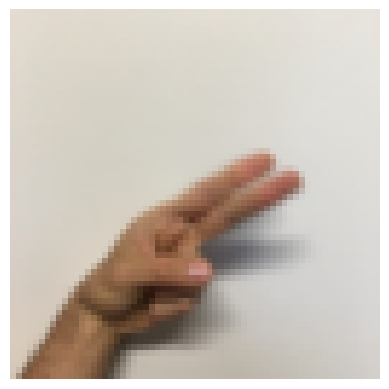

In [5]:
# Example of an image from the dataset
index = 2
plt.axis("off")
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

<a name='2-2'></a>
### 2.2 - Split the Data into Train/Test Sets

In Course 2, you built a fully-connected network for this dataset. But since this is an image dataset, it is more natural to apply a ConvNet to it.

To get started, let's examine the shapes of your data. 

In [6]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


<a name='2-3'></a>
### 2.3 - Forward Propagation

In TensorFlow, there are built-in functions that implement the convolution steps for you. By now, you should be familiar with how TensorFlow builds computational graphs. In the [Functional API](https://www.tensorflow.org/guide/keras/functional), you create a graph of layers. This is what allows such great flexibility.

Begin building your graph of layers by creating an input node that functions as a callable object:

- **input_img = tf.keras.Input(shape=input_shape):** 

Then, create a new node in the graph of layers by calling a layer on the `input_img` object: 

- **tf.keras.layers.Conv2D(filters= ... , kernel_size= ... , padding='same')(input_img):** Read the full documentation on [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

- **tf.keras.layers.MaxPool2D(pool_size=(f, f), strides=(s, s), padding='same'):** `MaxPool2D()` downsamples your input using a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, you usually operate on a single example at a time and a single channel at a time. Read the full documentation on [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

- **tf.keras.layers.ReLU():** computes the elementwise ReLU of Z (which can be any shape). You can read the full documentation on [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU).

- **tf.keras.layers.Flatten()**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  

    * If a tensor P has the shape (batch_size,h,w,c), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    
    * For example, given a tensor with dimensions [100, 2, 3, 4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4.  You can read the full documentation on [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).

- **tf.keras.layers.Dense(units= ... , activation='softmax')(F):** given the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation on [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

In the last function above (`tf.keras.layers.Dense()`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters.

Lastly, before creating the model, you'll need to define the output using the last of the function's compositions (in this example, a Dense layer): 

- **outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)**


#### Window, kernel, filter, pool

The words "kernel" and "filter" are used to refer to the same thing. The word "filter" accounts for the amount of "kernels" that will be used in a single convolution layer. "Pool" is the name of the operation that takes the max or average value of the kernels. 

This is why the parameter `pool_size` refers to `kernel_size`, and you use `(f,f)` to refer to the filter size. 

Pool size and kernel size refer to the same thing in different objects - They refer to the shape of the window where the operation takes place. 

<a name='ex-1'></a>
### function 1 - convolutional_model

Implement the `convolutional_model` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Use the functions above! 

Also, plug in the following parameters for all the steps:

 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 8 4 by 4 filters, stride 1, padding is "SAME"
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - **Conv2D**: Use 16 2 by 2 filters, stride 1, padding is "SAME"
 - **ReLU**
 - **MaxPool2D**: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 6 neurons and a softmax activation. 

In [7]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(filters = 8, kernel_size = (4,4), strides = 1, padding= "same")(input_img)
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=(8,8), strides=8, padding='same')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters = 16, kernel_size = (2,2), strides = 1, padding= "same")(P1)
    ## RELU
    A2 = tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D(pool_size=(4,4), strides=4, padding='same')(A2)
    ## FLATTEN
    F  = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(6,activation = "softmax")(F)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [19]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 8)         392       
                                                                 
 re_lu_10 (ReLU)             (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 8, 8, 8)           0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 16)          528       
                                                                 
 re_lu_11 (ReLU)             (None, 8, 8, 16)          0         
                                                           

Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are handled inside the object model! 

<a name='2-4'></a>
### 2.4 - Train the Model

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 1s 22ms/step - loss: 1.8128 - accuracy: 0.1611 - val_loss: 1.7856 - val_accuracy: 0.1750
Epoch 2/100
17/17 [==============================] - 0s 16ms/step - loss: 1.7852 - accuracy: 0.2315 - val_loss: 1.7781 - val_accuracy: 0.2833
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 1.7788 - accuracy: 0.2546 - val_loss: 1.7738 - val_accuracy: 0.3000
Epoch 4/100
17/17 [==============================] - 0s 16ms/step - loss: 1.7741 - accuracy: 0.2620 - val_loss: 1.7690 - val_accuracy: 0.3250
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 1.7688 - accuracy: 0.2981 - val_loss: 1.7632 - val_accuracy: 0.3250
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 1.7622 - accuracy: 0.3185 - val_loss: 1.7565 - val_accuracy: 0.3750
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 1.7543 - accuracy: 0.3315 - val_loss: 1.7475 - val_accuracy: 0.3833
Epoch 

<a name='3'></a>
## 3 - History Object 

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that you can retrieve at `history.history`: 

In [21]:
history.history

{'loss': [1.812828540802002,
  1.7852460145950317,
  1.7787649631500244,
  1.7741093635559082,
  1.768766164779663,
  1.7622486352920532,
  1.754311442375183,
  1.7448065280914307,
  1.7336407899856567,
  1.7207112312316895,
  1.7059061527252197,
  1.687951683998108,
  1.6671961545944214,
  1.6439002752304077,
  1.6175504922866821,
  1.5881975889205933,
  1.5571701526641846,
  1.5226421356201172,
  1.4872689247131348,
  1.4501168727874756,
  1.412724494934082,
  1.374599575996399,
  1.3368455171585083,
  1.2976455688476562,
  1.258602499961853,
  1.222071886062622,
  1.1853001117706299,
  1.1503340005874634,
  1.1157341003417969,
  1.0828965902328491,
  1.0519510507583618,
  1.0234401226043701,
  0.9963458180427551,
  0.9704301357269287,
  0.9449247717857361,
  0.9207450151443481,
  0.8986683487892151,
  0.8774704933166504,
  0.8576731085777283,
  0.8384057283401489,
  0.820173978805542,
  0.8030224442481995,
  0.7866334915161133,
  0.770896852016449,
  0.756368100643158,
  0.741868317

Now visualize the loss over time using `history.history`: 

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

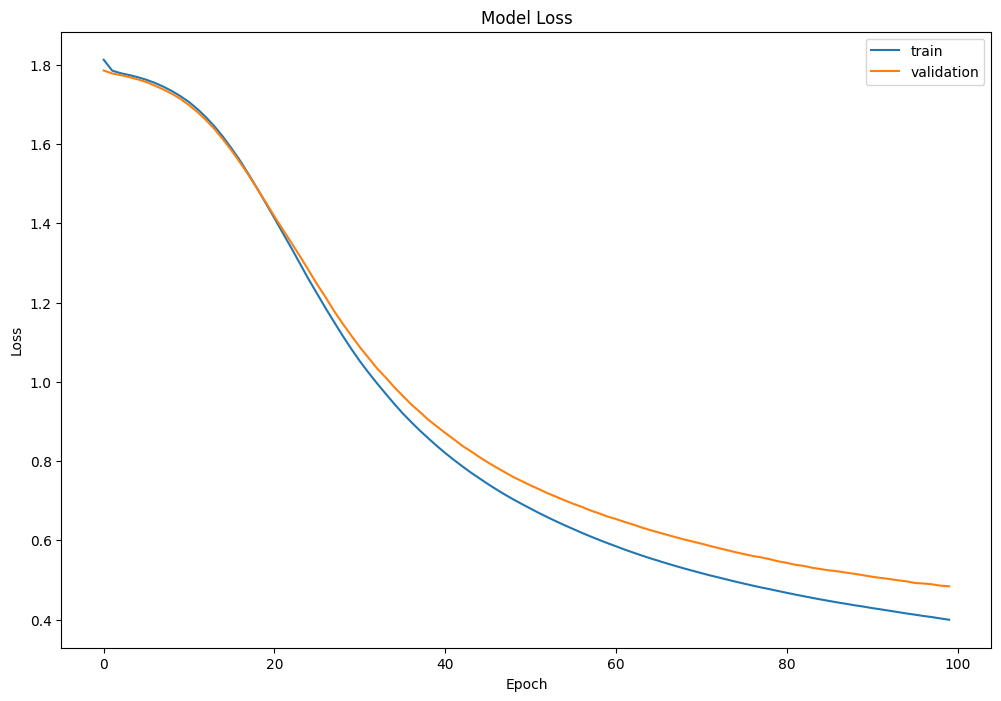

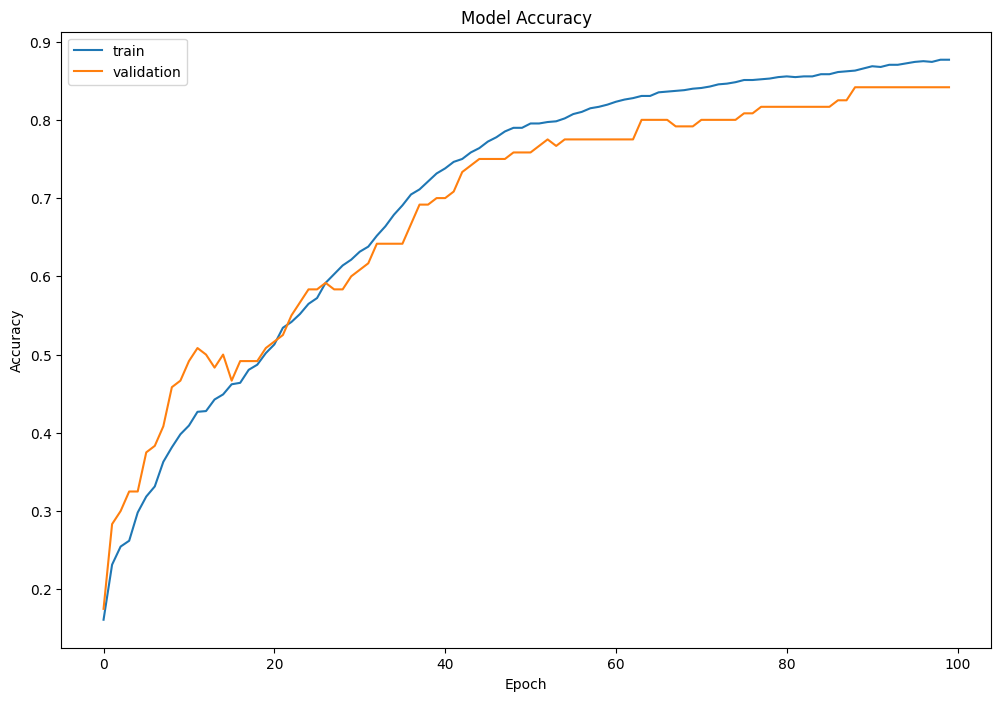

In [24]:
df_loss_acc = pd.DataFrame(history.history)

df_loss = df_loss_acc[['loss', 'val_loss']].copy()
df_loss.rename(columns={'loss':'train','val_loss':'validation'}, inplace=True)

df_acc = df_loss_acc[['accuracy', 'val_accuracy']].copy()
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'}, inplace=True)

df_loss.plot(title='Model Loss', figsize=(12,8)).set(xlabel='Epoch', ylabel='Loss')
df_acc.plot(title='Model Accuracy', figsize=(12,8)).set(xlabel='Epoch', ylabel='Accuracy')

### Easy Right?, Let's try it🤩

1/1 [==============================] - 0s 26ms/step
y = 0


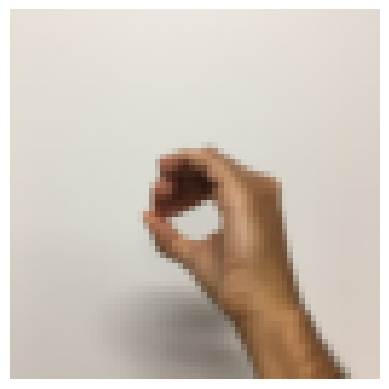

In [32]:
index = 0
prediction = np.argmax(conv_model.predict(np.expand_dims(X_test[index], axis= 0)))
plt.axis("off")
plt.imshow(X_test_orig[index])
print ("y = " + str(prediction))

1/1 [==============================] - 0s 27ms/step
y = 1


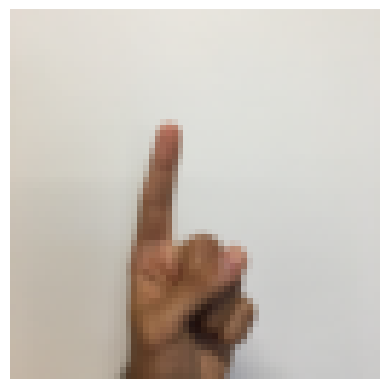

In [36]:
index = 4
prediction = np.argmax(conv_model.predict(np.expand_dims(X_test[index], axis= 0)))
plt.axis("off")
plt.imshow(X_test_orig[index])
print ("y = " + str(prediction))

1/1 [==============================] - 0s 33ms/step
y = 2


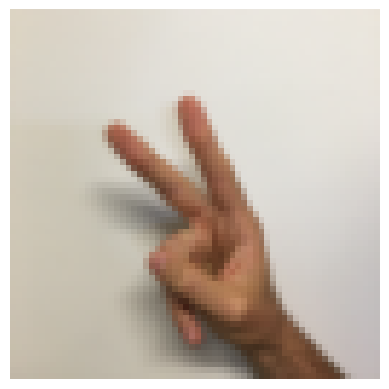

In [54]:
index = 22
prediction = np.argmax(conv_model.predict(np.expand_dims(X_test[index], axis= 0)))
plt.axis("off")
plt.imshow(X_test_orig[index])
print ("y = " + str(prediction))

1/1 [==============================] - 0s 28ms/step
y = 3


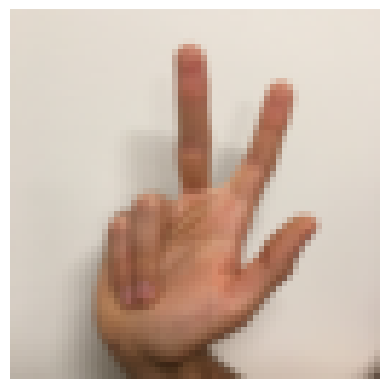

In [38]:
index = 6
prediction = np.argmax(conv_model.predict(np.expand_dims(X_test[index], axis= 0)))
plt.axis("off")
plt.imshow(X_test_orig[index])
print ("y = " + str(prediction))

1/1 [==============================] - 0s 30ms/step
y = 4


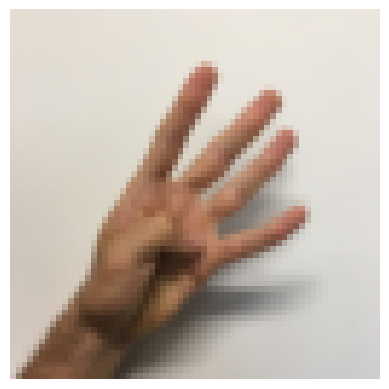

In [49]:
index = 17
prediction = np.argmax(conv_model.predict(np.expand_dims(X_test[index], axis= 0)))
plt.axis("off")
plt.imshow(X_test_orig[index])
print ("y = " + str(prediction))

1/1 [==============================] - 0s 25ms/step
y = 5


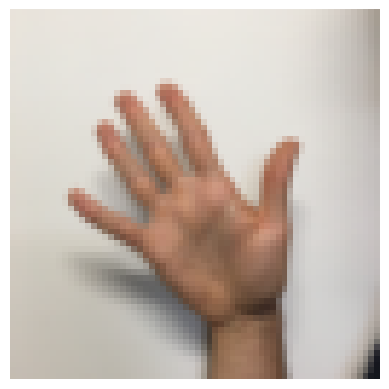

In [35]:
index = 3
prediction = np.argmax(conv_model.predict(np.expand_dims(X_test[index], axis= 0)))
plt.axis("off")
plt.imshow(X_test_orig[index])
print ("y = " + str(prediction))

## Finished🤩🤩

<a name='4'></a>
## 4 - Bibliography

You're always encouraged to read the official documentation. To that end, you can find the docs for the Sequential and Functional APIs here: 


https://www.tensorflow.org/guide/keras/functional